times assume cosmology from planck2015:

Omega_m = 0.31, Omega_l = 0.69, Omega_b = 0.048,
h = 0.68, sigma_8 = 0.82, n_s = 0.97

i scale-factor redshift time[Gyr] lookback-time[Gyr] time-width[Myr]

332 0.587579608  0.701897025  7.265212114  6.471003908  26.1623

In [1]:
import gizmo_analysis as gizmo  # rename these packages for brevity
import utilities as ut  # rename these packages for brevity

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as cl
from scipy.stats import gaussian_kde

In [2]:
gizmo.io

<module 'gizmo_analysis.gizmo_io' from '/home/baparker/code/gizmo_analysis/gizmo_io.py'>

In [3]:
simulation_directory = '/home/baparker/GitHub/Coursework/ASTR-513/HW/Project/m12r_res7100'

In [4]:
part = gizmo.io.Read.read_snapshots('all', 'redshift', 0.702, simulation_directory)


# in utilities.simulation.Snapshot():
* reading:  home/baparker/GitHub/Coursework/ASTR-513/HW/Project/m12r_res7100/snapshot_times.txt

* input redshift = 0.702:  using snapshot index = 332, redshift = 0.702


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/baparker/GitHub/Coursework/ASTR-513/HW/Project/m12r_res7100/output/snapdir_332/snapshot_332.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 60327928 particles
    dark2     (id = 2): 6226512 particles
    gas       (id = 0): 58520742 particles
    star      (id = 4): 1820812 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['dark', 'dark2', 'gas', 'star']

* reading particles from:
    snapshot_332.0.hdf5
    snapshot_332.1.hdf5
    snapshot_332.2.hdf5
    snapshot_332.3.hdf5

* reading cosmological parameters from:  home/baparker/GitHub/Coursework/ASTR-513/HW/Project/m12r_res7100/initial_condition/ic_L172_m12r.conf

* checking sanity of particl

In [5]:
part['gas'].keys()

dict_keys(['position', 'density', 'electron.fraction', 'temperature', 'mass', 'massfraction', 'hydrogen.neutral.fraction', 'id.child', 'id.generation', 'id', 'potential', 'size', 'sfr', 'velocity'])

In [6]:
gas_loc = part['gas']['position']
gas_temp = part['gas']['temperature']
gas_den = part['gas']['density']

In [7]:
np.shape(gas_loc)

(58520742, 3)

In [66]:
x = gas_loc[::10, 0]
y = gas_loc[::10, 1]
z = gas_loc[::10, 2]
temp = gas_temp[::10]
dens = gas_den[::10]
nH = part['gas'].prop('number.density')[::10]
mass_frac = part['gas']['massfraction'][::10, 0]
mass_frac_tot = np.sum(part['gas']['massfraction'][::10, :], axis=1)

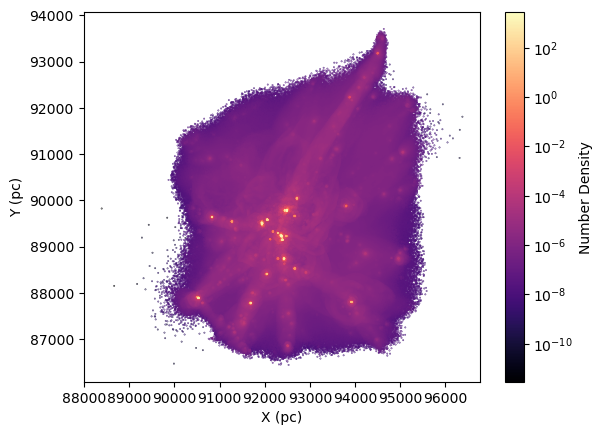

In [33]:
ind = np.argsort(nH)

plt.scatter(y[ind], z[ind], c = nH[ind], s=0.1, norm=cl.LogNorm(), cmap = 'magma')
plt.xlabel('X (pc)')
plt.ylabel('Y (pc)')
plt.colorbar(label = 'Number Density')

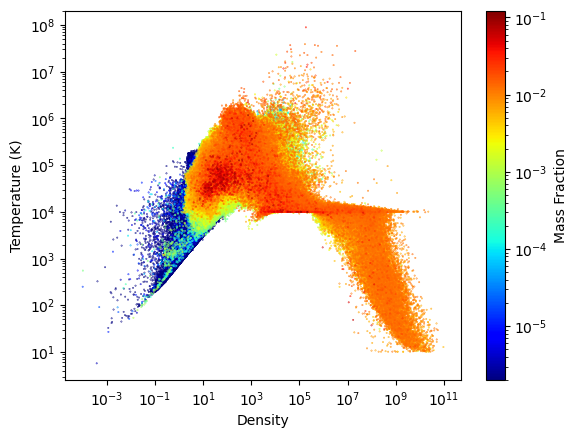

In [65]:
ind = np.argsort(mass_frac)

plt.scatter(dens[ind], temp[ind], c = mass_frac[ind], s=0.1, norm=cl.LogNorm(), cmap='jet')
plt.xlabel('Density')
plt.ylabel('Temperature (K)')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label = 'Mass Fraction')
plt.title('

In [68]:
np.shape(mass_frac_tot)

(5852075,)

In [ ]:
ind = np.argsort(mass_frac)

plt.scatter(dens[ind], temp[ind], c = mass_frac[ind], s=0.1, norm=cl.LogNorm(), cmap='jet')
plt.xlabel('Density')
plt.ylabel('Temperature (K)')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label = 'Mass Fraction')